# Семантическая Сегментация. Часть 1.

## Переключение версии TensorFlow

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import random
import imageio
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf

## Загрузка данных
`me_256.png` - Изображение

`me_gt_256.png` - Карта сагментации (человек/фон)

In [3]:
if 1:
    !wget https://raw.githubusercontent.com/dkorobchenko-nv/person-segmentation/master/img/me_256.png
    !wget https://raw.githubusercontent.com/dkorobchenko-nv/person-segmentation/master/img/me_gt_256.png

--2020-03-21 11:04:12--  https://raw.githubusercontent.com/dkorobchenko-nv/person-segmentation/master/img/me_256.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118993 (116K) [image/png]
Saving to: ‘me_256.png’

me_256.png          100%[===================>] 116.20K  --.-KB/s    in 0.001s  

2020-03-21 11:04:12 (86.6 MB/s) - ‘me_256.png’ saved [118993/118993]

--2020-03-21 11:04:13--  https://raw.githubusercontent.com/dkorobchenko-nv/person-segmentation/master/img/me_gt_256.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2965 (2.9K)

## Визуализация данных

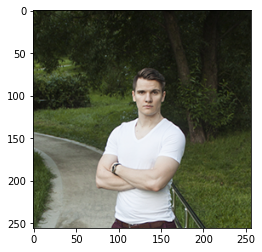

In [4]:
img = imageio.imread('me_256.png')
img = img.astype(np.float32) / 255.
_=plt.imshow(img)

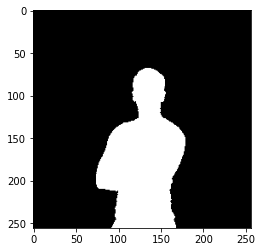

In [6]:
gt = imageio.imread('me_gt_256.png')
gt = gt.astype(np.float32) / 255.
gt = np.mean(gt, axis=2)[..., None]
_=plt.imshow(gt[...,0], cmap='gray')

## Создание "игрушечного" сегментационного датасета
Датасет очень маленький, модель скорее всего переобучится.
Наша цель - проверить работоспособность пайплайна.

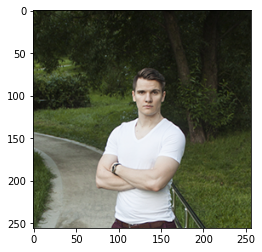

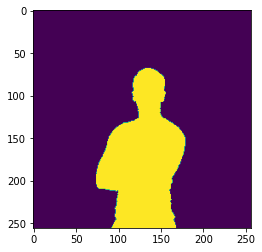

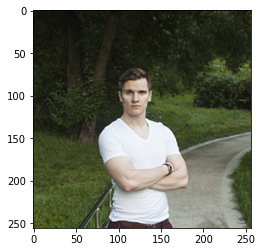

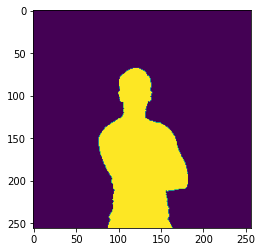

(<matplotlib.image.AxesImage at 0x7f03d2b0ebe0>, None)

In [7]:
train_x = np.stack((img, img[:,::-1,:]))
train_y = np.stack((gt, gt[:,::-1,:]))

plt.imshow(train_x[0]), plt.show()
plt.imshow(train_y[0][...,0]), plt.show()
plt.imshow(train_x[1]), plt.show()
plt.imshow(train_y[1][...,0]), plt.show()

## Создание модели U-Net

In [0]:
# U-Net
def build_model():
    x = tf.keras.layers.Input((256, 256, 3))
    
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    out1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out1)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out2)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out4 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out4)

    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out4, out], axis=3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out3, out], axis=3)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out2, out], axis=3)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out1, out], axis=3)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)

    return tf.keras.Model(inputs=x, outputs=out)

model = build_model()

## Визуализация U-Net

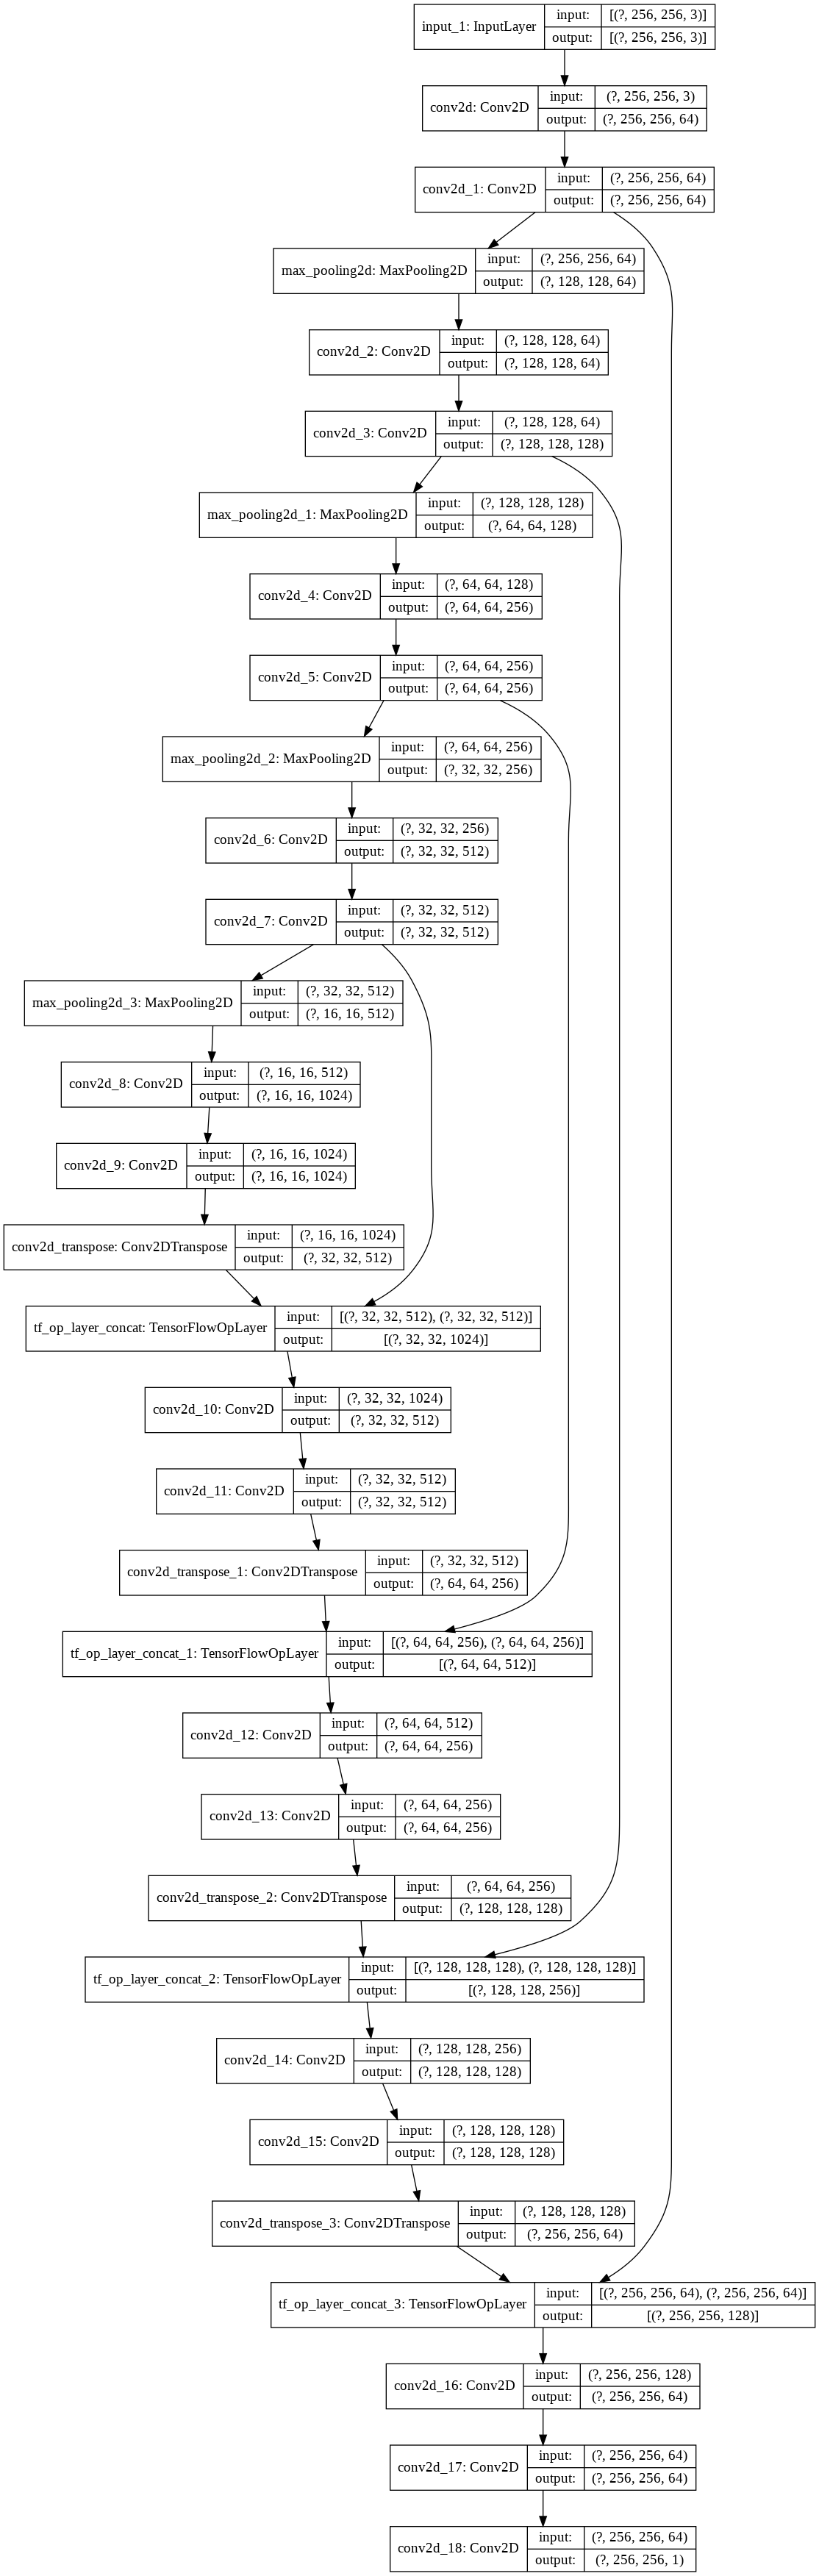

In [9]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Обучение модели

Train on 2 samples
Epoch 1/100
2/2 [==============================] - 10s 5s/sample - loss: 0.6856
Epoch 2/100
2/2 [==============================] - 0s 124ms/sample - loss: 0.6582
Epoch 3/100
2/2 [==============================] - 0s 123ms/sample - loss: 0.5427
Epoch 4/100
2/2 [==============================] - 0s 121ms/sample - loss: 5.0248
Epoch 5/100
2/2 [==============================] - 0s 123ms/sample - loss: 0.6402
Epoch 6/100
2/2 [==============================] - 0s 122ms/sample - loss: 0.7011
Epoch 7/100
2/2 [==============================] - 0s 122ms/sample - loss: 0.6897
Epoch 8/100
2/2 [==============================] - 0s 122ms/sample - loss: 0.7787
Epoch 9/100
2/2 [==============================] - 0s 121ms/sample - loss: 0.6832
Epoch 10/100
2/2 [==============================] - 0s 121ms/sample - loss: 0.6792
Epoch 11/100
2/2 [==============================] - 0s 122ms/sample - loss: 0.6699
Epoch 12/100
2/2 [==============================] - 0s 123ms/sample - loss: 0.6

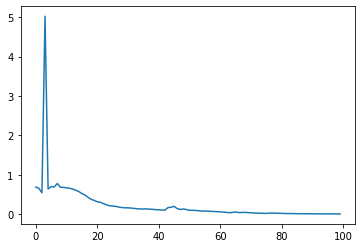

In [10]:
NUM_EPOCHS = 100
BATCH_SIZE = 1

loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam', loss=loss)

hist = model.fit(train_x, train_y, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS)

plt.plot(hist.history['loss'])

## Пример результата сегментации

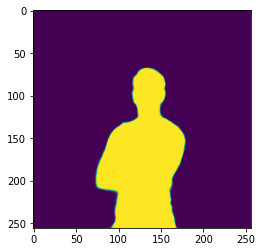

In [11]:
out = model.predict(img[None, ...])[0, ...]
_=plt.imshow(out[...,0])

## Наложение карты сегментации на изображение

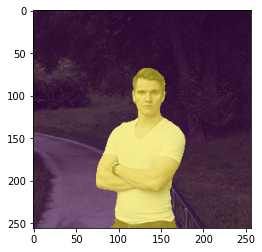

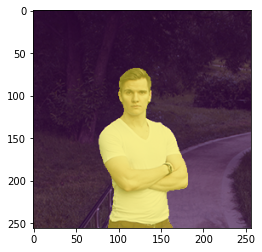

In [12]:
for sample in train_x:
    out = model.predict(sample[None, ...])
    seg_map = (out[0, ..., 0]>0.5).astype(np.float32)
    seg_map_clr = plt.get_cmap('viridis')(seg_map)[..., :3]
    plt.imshow(sample*0.5 + seg_map_clr*0.5)
    plt.show()